1) 총대출금액 : 정규화 (유의미한 차이가 있음) <br>
2) Train - Test Split <br>
3) TrainSet - RobustSccaling 함 , Test RobustScaling 함<br>
4) TrainSet - OverSampling 함 <br>

모든 모델은 오로지 Train Set에만 훈련시켜야하며 이로써 새로운 데이터 즉 테스트셋을 예측할 수 있다

In [1]:
#필요 라이브러리
import pandas as pd
import numpy as np

#################### Train_Test Split ######################
from sklearn.model_selection import train_test_split


#################### 성능평가 ############################
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import sklearn
#################### XGBoost ###########################
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV


################## lgbm ###########################
from lightgbm import LGBMClassifier

##################### Decision Tree #######################
from sklearn.tree import DecisionTreeClassifier

################## RandomForest ##########################
from sklearn.ensemble import RandomForestClassifier

###################### Logistic Rregression ###############
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore')

In [2]:
#모델 성능 평가 함수화
def model_assessment(test,pred):
    confusion = confusion_matrix(test, pred)
    accuracy = accuracy_score(test,pred)
    report = metrics.classification_report(test, pred, digits=2)
    
    print('accuracy', accuracy, '\n')
    print('confusion_matrix',confusion, '\n')
    print(report)

In [3]:
import pandas as pd 
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [4]:
#시각화 패키지 라이브러리
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Malgun Gothic' #한글깨짐현상방지
matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
df = pd.read_csv('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/data/Corona19_Classification_data.csv',encoding='cp949')

In [7]:
len(df)

977390

In [8]:
len(df.columns)

63

In [9]:
df_m = df

해당 데이터로 분류 모델링을 수행하기 위해서는 JOIN_KEY 속성이 배제돼야함

In [10]:
df_m.drop(columns=['JOIN_KEY','생년월일'],inplace=True)
df_m['성별']  = df_m['성별'].astype(str)
sex_onehot = pd.get_dummies(df_m['성별'])
sex_onehot.drop(columns=['1'], inplace=True)
sex_onehot = sex_onehot.rename(columns={'2':'성별'})
df_m.drop(columns=['성별'], inplace = True)
df_m = pd.concat([df_m, sex_onehot], axis=1)

In [11]:
df_m['성별'] = df_m['성별'].astype('int')

In [12]:
#연체여부 종속변수는 int로 변환
df_m['연체여부'] = df_m['연체여부'].map({'0':0,"b'1'":1})

# 1. 총대출금액 정규화

정규화 log normalization은 총대출금액에 아주 유의미한 차이를 보임

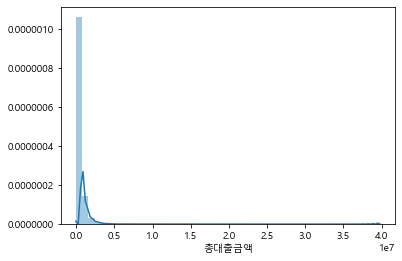

In [14]:
sns.distplot(df_m['총대출금액'])

In [15]:
df_m['총대출금액'] = np.log1p(df_m['총대출금액'])

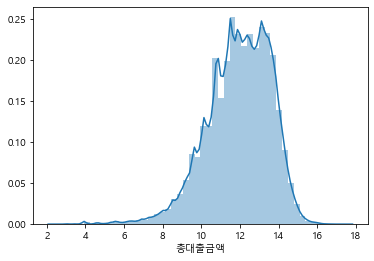

In [16]:
sns.distplot(df_m['총대출금액'])

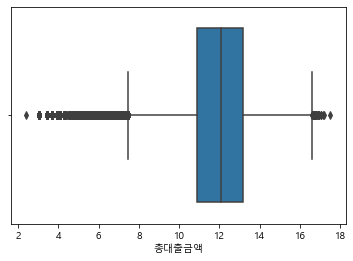

In [17]:
sns.boxplot(df_m['총대출금액'])

# 1. Train - Test Split

해당 데이터에서 정상인 케이스 비율이 전체의 약 99.65%, 채무불이행(연체)가 약 0.35%임

In [18]:
df_m['연체여부'].value_counts() / df_m['연체여부'].value_counts().sum() *100

0    99.647121
1     0.352879
Name: 연체여부, dtype: float64

In [19]:
#시각화 패키지 라이브러리
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Malgun Gothic' #한글깨짐현상방지
matplotlib.rcParams['axes.unicode_minus'] = False

Text(0.5, 1.0, '연체여부 \n (0:정상 || 1:채무불이행)')

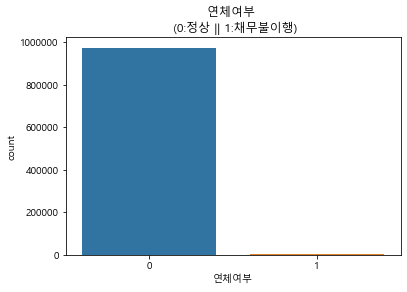

In [20]:
sns.countplot('연체여부', data = df_m)
plt.title('연체여부 \n (0:정상 || 1:채무불이행)')

In [21]:
#독립변수
X = df_m.drop(columns=['연체여부'])
y = df_m['연체여부']

* Random State seed 주는 것 보류

In [22]:
#stratify = y는 클래스 비율을 유지 즉 위의 0: 97.53 %  || 1: 2.47% 비율을 Train-Test에도 동일 적용

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=156)
print(X_train.shape, X_test.shape)

(684173, 60) (293217, 60)


In [23]:
y_train.value_counts() / y_train.value_counts().sum() *100

0    99.647165
1     0.352835
Name: 연체여부, dtype: float64

In [24]:
y_test.value_counts() / y_test.value_counts().sum() *100

0    99.647019
1     0.352981
Name: 연체여부, dtype: float64

In [25]:
#.to_csv('C:/Users/ksy/Desktop/개인/CreDB예시/data/SMOTEENN용/X_test.csv')

In [26]:
#y_test.to_csv('C:/Users/ksy/Desktop/개인/CreDB예시/data/SMOTEENN용/y_test.csv')

In [27]:
#X_train.to_csv('C:/Users/ksy/Desktop/개인/CreDB예시/data/SMOTEENN용/X_train.csv')

In [28]:
#y_train.to_csv('C:/Users/ksy/Desktop/개인/CreDB예시/data/SMOTEENN용/y_train.csv')

In [29]:
X_train.shape

(684173, 60)

In [30]:
X_test.shape

(293217, 60)

In [31]:
y_train.shape

(684173,)

In [32]:
y_test.shape

(293217,)

# 2. Scaling의 필요성

스케일링은 모델에 영향을 주는 feature들의 데이터 간격차와 연산량을 줄이기 위해 실시

In [33]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
robust = RobustScaler()
minmax = MinMaxScaler()

## 1. 나이 - Min - max Scaling
## 2. 대출금액, 대출건수 - Robust Scaling (이상치 덜 민감)
## 3. 성별 - 스케일링 안함

# 2-1 ) Train Set

In [35]:
나이 = X_train[['나이']]
성별 = X_train[['성별']]
성별 = 성별.reset_index()
성별.drop(columns=['index'], inplace=True)

In [36]:
나이_scaled = minmax.fit_transform(나이.values)
나이_scaled = pd.DataFrame(나이_scaled, columns=나이.columns)

In [37]:
나이 = 나이_scaled

In [38]:
import pickle as pkl
with open("MinMax.pkl",'wb') as outfile:
    pkl.dump(minmax,outfile)

In [39]:
X_train = X_train.drop(columns=['나이','성별'])

In [40]:
X_train.shape

(684173, 58)

## ★★★★★★★★★ FIT_TRANSFORM ★★★★★★★★★★으로 Train_set 기준으로 Scaling함

In [1]:
X_train.head()

In [42]:
scaled = robust.fit_transform(X_train.values)
X_train = pd.DataFrame(scaled, columns=X_train.columns)

In [44]:
X_train = pd.concat([X_train,나이], axis=1)
X_train = pd.concat([X_train,성별], axis=1)

# 스케일러 저장

In [46]:
import pickle as pkl
with open("robust.pkl",'wb') as outfile:
    pkl.dump(robust,outfile)

# 2-2) Test Set

In [48]:
나이 = X_test[['나이']]
성별 = X_test[['성별']]
나이 = 나이.reset_index()
나이.drop(columns=['index'], inplace=True)
성별 = 성별.reset_index()
성별.drop(columns=['index'], inplace=True)
X_test = X_test.drop(columns=['나이','성별'])

In [49]:
len(X_test)

293217

저장된 스케일러 불러오기

### 나이 minmax

In [50]:
with open('MinMax.pkl','rb') as infile:
    minmax = pkl.load(infile)
    나이_scaled = minmax.transform(나이.values)
    나이_scaled = pd.DataFrame(나이_scaled, columns=나이.columns)
    나이 = 나이_scaled

### 그 외 변수 robust

In [51]:
with open('robust.pkl','rb') as infile:
    robust = pkl.load(infile)
    scaled = robust.transform(X_test.values)
    X_test = pd.DataFrame(scaled, columns=X_test.columns)

In [53]:
X_test = pd.concat([X_test,나이], axis=1)
X_test = pd.concat([X_test,성별], axis=1)

In [54]:
X_train.shape

(684173, 60)

In [55]:
X_test.shape

(293217, 60)

In [56]:
X_train.columns

Index(['대출건수_5개월_1', '대출건수_5개월_3', '대출건수_5개월_5', '대출건수_5개월_6', '대출건수_5개월_8',
       '대출건수_5개월_17', '대출건수_5개월_21', '대출건수_5개월_98', '대출금액_5개월_1', '대출금액_5개월_3',
       '대출금액_5개월_5', '대출금액_5개월_6', '대출금액_5개월_8', '대출금액_5개월_17', '대출금액_5개월_21',
       '대출금액_5개월_98', '대출건수_5개월_0', '대출건수_5개월_100', '대출건수_5개월_150',
       '대출건수_5개월_170', '대출건수_5개월_200', '대출건수_5개월_210', '대출건수_5개월_220',
       '대출건수_5개월_230', '대출건수_5개월_240', '대출건수_5개월_245', '대출건수_5개월_250',
       '대출건수_5개월_270', '대출건수_5개월_271', '대출건수_5개월_290', '대출건수_5개월_500',
       '대출건수_5개월_510', '대출건수_5개월_590', '대출건수_5개월_700', '대출건수_5개월_710',
       '대출금액_5개월_0', '대출금액_5개월_100', '대출금액_5개월_150', '대출금액_5개월_170',
       '대출금액_5개월_200', '대출금액_5개월_210', '대출금액_5개월_220', '대출금액_5개월_230',
       '대출금액_5개월_240', '대출금액_5개월_245', '대출금액_5개월_250', '대출금액_5개월_270',
       '대출금액_5개월_271', '대출금액_5개월_290', '대출금액_5개월_500', '대출금액_5개월_510',
       '대출금액_5개월_590', '대출금액_5개월_700', '대출금액_5개월_710', '개설카드수5', '총대출금액',
       '총대출건수', '총대출상품수', '나이', '성별'],
      dtype='obje

In [57]:
X_test.columns

Index(['대출건수_5개월_1', '대출건수_5개월_3', '대출건수_5개월_5', '대출건수_5개월_6', '대출건수_5개월_8',
       '대출건수_5개월_17', '대출건수_5개월_21', '대출건수_5개월_98', '대출금액_5개월_1', '대출금액_5개월_3',
       '대출금액_5개월_5', '대출금액_5개월_6', '대출금액_5개월_8', '대출금액_5개월_17', '대출금액_5개월_21',
       '대출금액_5개월_98', '대출건수_5개월_0', '대출건수_5개월_100', '대출건수_5개월_150',
       '대출건수_5개월_170', '대출건수_5개월_200', '대출건수_5개월_210', '대출건수_5개월_220',
       '대출건수_5개월_230', '대출건수_5개월_240', '대출건수_5개월_245', '대출건수_5개월_250',
       '대출건수_5개월_270', '대출건수_5개월_271', '대출건수_5개월_290', '대출건수_5개월_500',
       '대출건수_5개월_510', '대출건수_5개월_590', '대출건수_5개월_700', '대출건수_5개월_710',
       '대출금액_5개월_0', '대출금액_5개월_100', '대출금액_5개월_150', '대출금액_5개월_170',
       '대출금액_5개월_200', '대출금액_5개월_210', '대출금액_5개월_220', '대출금액_5개월_230',
       '대출금액_5개월_240', '대출금액_5개월_245', '대출금액_5개월_250', '대출금액_5개월_270',
       '대출금액_5개월_271', '대출금액_5개월_290', '대출금액_5개월_500', '대출금액_5개월_510',
       '대출금액_5개월_590', '대출금액_5개월_700', '대출금액_5개월_710', '개설카드수5', '총대출금액',
       '총대출건수', '총대출상품수', '나이', '성별'],
      dtype='obje

In [58]:
X_train.isnull().sum()

대출건수_5개월_1      0
대출건수_5개월_3      0
대출건수_5개월_5      0
대출건수_5개월_6      0
대출건수_5개월_8      0
대출건수_5개월_17     0
대출건수_5개월_21     0
대출건수_5개월_98     0
대출금액_5개월_1      0
대출금액_5개월_3      0
대출금액_5개월_5      0
대출금액_5개월_6      0
대출금액_5개월_8      0
대출금액_5개월_17     0
대출금액_5개월_21     0
대출금액_5개월_98     0
대출건수_5개월_0      0
대출건수_5개월_100    0
대출건수_5개월_150    0
대출건수_5개월_170    0
대출건수_5개월_200    0
대출건수_5개월_210    0
대출건수_5개월_220    0
대출건수_5개월_230    0
대출건수_5개월_240    0
대출건수_5개월_245    0
대출건수_5개월_250    0
대출건수_5개월_270    0
대출건수_5개월_271    0
대출건수_5개월_290    0
대출건수_5개월_500    0
대출건수_5개월_510    0
대출건수_5개월_590    0
대출건수_5개월_700    0
대출건수_5개월_710    0
대출금액_5개월_0      0
대출금액_5개월_100    0
대출금액_5개월_150    0
대출금액_5개월_170    0
대출금액_5개월_200    0
대출금액_5개월_210    0
대출금액_5개월_220    0
대출금액_5개월_230    0
대출금액_5개월_240    0
대출금액_5개월_245    0
대출금액_5개월_250    0
대출금액_5개월_270    0
대출금액_5개월_271    0
대출금액_5개월_290    0
대출금액_5개월_500    0
대출금액_5개월_510    0
대출금액_5개월_590    0
대출금액_5개월_700    0
대출금액_5개월_710    0
개설카드수5          0
총대출금액     

In [59]:
X_test.isnull().sum()

대출건수_5개월_1      0
대출건수_5개월_3      0
대출건수_5개월_5      0
대출건수_5개월_6      0
대출건수_5개월_8      0
대출건수_5개월_17     0
대출건수_5개월_21     0
대출건수_5개월_98     0
대출금액_5개월_1      0
대출금액_5개월_3      0
대출금액_5개월_5      0
대출금액_5개월_6      0
대출금액_5개월_8      0
대출금액_5개월_17     0
대출금액_5개월_21     0
대출금액_5개월_98     0
대출건수_5개월_0      0
대출건수_5개월_100    0
대출건수_5개월_150    0
대출건수_5개월_170    0
대출건수_5개월_200    0
대출건수_5개월_210    0
대출건수_5개월_220    0
대출건수_5개월_230    0
대출건수_5개월_240    0
대출건수_5개월_245    0
대출건수_5개월_250    0
대출건수_5개월_270    0
대출건수_5개월_271    0
대출건수_5개월_290    0
대출건수_5개월_500    0
대출건수_5개월_510    0
대출건수_5개월_590    0
대출건수_5개월_700    0
대출건수_5개월_710    0
대출금액_5개월_0      0
대출금액_5개월_100    0
대출금액_5개월_150    0
대출금액_5개월_170    0
대출금액_5개월_200    0
대출금액_5개월_210    0
대출금액_5개월_220    0
대출금액_5개월_230    0
대출금액_5개월_240    0
대출금액_5개월_245    0
대출금액_5개월_250    0
대출금액_5개월_270    0
대출금액_5개월_271    0
대출금액_5개월_290    0
대출금액_5개월_500    0
대출금액_5개월_510    0
대출금액_5개월_590    0
대출금액_5개월_700    0
대출금액_5개월_710    0
개설카드수5          0
총대출금액     

## 3. SMOTE OverSampling

Train Data Set에 대하여 Smote OverSampling 실행

원래 아이디어는 smote -> undersampling 해서 모델링 시간을 줄이려했지만...

In [60]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=7) # RandomState 변경
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [61]:
print('SMOTE 적용 후 Data Set Size', X_train_over.shape, y_train_over.shape)

SMOTE 적용 후 Data Set Size (1363518, 60) (1363518,)


In [62]:
print('SMOTE 적용 후 Class 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 후 Class 분포:
 1    681759
0    681759
Name: 연체여부, dtype: int64


Text(0.5, 1.0, '연체여부 \n (0:정상 || 1:채무불이행)')

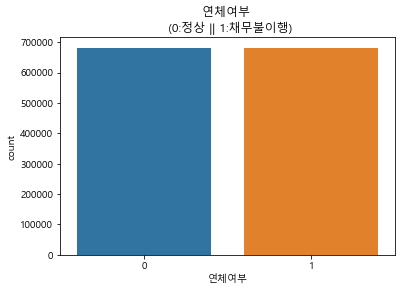

In [62]:
sns.countplot('연체여부', data = y_train_over.to_frame())
plt.title('연체여부 \n (0:정상 || 1:채무불이행)')

# Modelling

In [63]:
def auc_return(y_test, pred):
    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test,pred)
    auc = metrics.auc(fpr,tpr)
    return auc

# 1. Regression

전통적으로 채무불이행 예측 모델은 다음과 같은 기본 알고리즘을 많이 사용함. 그 이유는 채무불이행 이유에 대한 '설명가능성'이 있기 때문 <br>
보수적인 금융권 특성, 고객과의 신뢰 등을 이유로 알고리즘의 설명 가능성에 대해 매우 민감함 <br>

## 1-1) Logistic

In [66]:
from sklearn.linear_model import LogisticRegression

In [66]:
lr = LogisticRegression()

In [68]:
lr.fit(X_train_over,y_train_over)

LogisticRegression()

In [64]:
with open('Logistc_Regression_predict.pkl','rb') as infile:
    lr_pred = pkl.load(infile)

In [69]:
lr_pred = lr.predict(X_test)

In [68]:
model_assessment(y_test, lr_pred)

accuracy 0.6582701548682375 

confusion_matrix [[192200  99982]
 [   219    816]] 

              precision    recall  f1-score   support

           0       1.00      0.66      0.79    292182
           1       0.01      0.79      0.02      1035

    accuracy                           0.66    293217
   macro avg       0.50      0.72      0.40    293217
weighted avg       1.00      0.66      0.79    293217



In [70]:
model_assessment(y_test, lr_pred)

accuracy 0.6582701548682375 

confusion_matrix [[192200  99982]
 [   219    816]] 

              precision    recall  f1-score   support

           0       1.00      0.66      0.79    292182
           1       0.01      0.79      0.02      1035

    accuracy                           0.66    293217
   macro avg       0.50      0.72      0.40    293217
weighted avg       1.00      0.66      0.79    293217



In [85]:
auc = auc_return(y_test,lr_pred)# 변경
auc = auc.round(2)
print(auc)

0.72


In [82]:
auc

0.7231074854178143

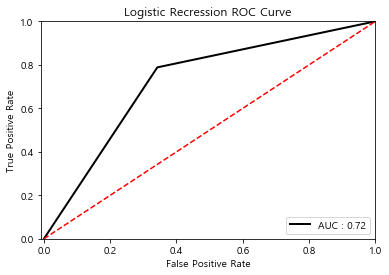

In [86]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, lr_pred)
plt.title('Logistic Recression ROC Curve')
plt.plot(fpr, tpr, 'k-', linewidth=2, label = 'AUC : ' + str(auc))
plt.legend(loc=4)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis([-0.01, 1,0,1])
plt.savefig('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/시나리오1/png/Logistic Regression ROC.png')
plt.show()

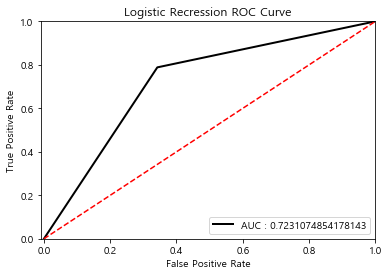

In [81]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, lr_pred)
plt.title('Logistic Recression ROC Curve')
plt.plot(fpr, tpr, 'k-', linewidth=2, label = 'AUC : ' + str(auc))
plt.legend(loc=4)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis([-0.01, 1,0,1])
plt.savefig('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/시나리오1/png/Logistic Regression ROC.png')
plt.show()

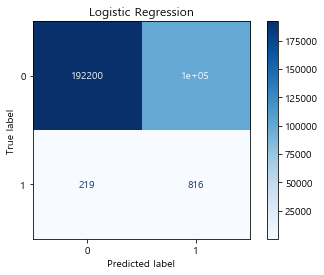

In [73]:
plot_confusion_matrix(lr,X_test,y_test,cmap='Blues')

plt.title('Logistic Regression')

plt.savefig('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/시나리오1/png/1.Logistic Regression Confusion Matrix.png')
plt.show()

In [74]:
#모델저장
import pickle as pkl
with open("Logistc_Regression.pkl",'wb') as outfile:
    pkl.dump(lr,outfile)

In [75]:
#모델저장
import pickle as pkl
with open("Logistc_Regression_predict.pkl",'wb') as outfile:
    pkl.dump(lr_pred,outfile)

# 2. Classification

### 2-1) XGBOOST

In [76]:
#X_test.head()

In [77]:
######기본모델
xgb_over_model = XGBClassifier(n_estimators=100,
                              objective='binary:logistic',
                              seed=156,
                              learning_rate=0.01)
xgb_over_model.fit(X_train_over, y_train_over, early_stopping_rounds=10, eval_set = [(X_train_over, y_train_over), (X_test, y_test)], eval_metric='logloss')

[0]	validation_0-logloss:0.68868	validation_1-logloss:0.68741
[1]	validation_0-logloss:0.68121	validation_1-logloss:0.68229
[2]	validation_0-logloss:0.67753	validation_1-logloss:0.67666
[3]	validation_0-logloss:0.67065	validation_1-logloss:0.67157
[4]	validation_0-logloss:0.66711	validation_1-logloss:0.66616
[5]	validation_0-logloss:0.66045	validation_1-logloss:0.66119
[6]	validation_0-logloss:0.65633	validation_1-logloss:0.65629
[7]	validation_0-logloss:0.65103	validation_1-logloss:0.65149
[8]	validation_0-logloss:0.64634	validation_1-logloss:0.64663
[9]	validation_0-logloss:0.64153	validation_1-logloss:0.64187
[10]	validation_0-logloss:0.63702	validation_1-logloss:0.63746
[11]	validation_0-logloss:0.63203	validation_1-logloss:0.63291
[12]	validation_0-logloss:0.62765	validation_1-logloss:0.62855
[13]	validation_0-logloss:0.62328	validation_1-logloss:0.62409
[14]	validation_0-logloss:0.61954	validation_1-logloss:0.61968
[15]	validation_0-logloss:0.61497	validation_1-logloss:0.61567
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=156,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=156,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [79]:
xgb_over_pred = xgb_over_model.predict(X_test)

In [80]:
print('<OverSampling 후 XGBoost 기본 모델 성능>')
model_assessment(y_test, xgb_over_pred)

<OverSampling 후 XGBoost 기본 모델 성능>
accuracy 0.8322709801955548 

confusion_matrix [[243434  48748]
 [   433    602]] 

              precision    recall  f1-score   support

           0       1.00      0.83      0.91    292182
           1       0.01      0.58      0.02      1035

    accuracy                           0.83    293217
   macro avg       0.51      0.71      0.47    293217
weighted avg       0.99      0.83      0.91    293217



In [81]:
auc = auc_return(y_test,xgb_over_pred) # 변경
print(auc)

0.7074006483352295


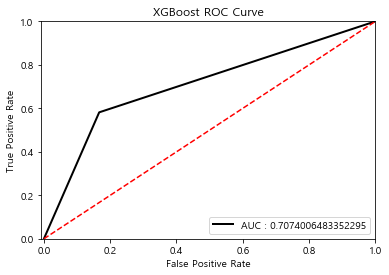

In [82]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, 
                                                xgb_over_pred) ##############
plt.title('XGBoost ROC Curve') ################
plt.plot(fpr, tpr, 'k-', linewidth=2,label = 'AUC : ' + str(auc))
plt.legend(loc=4)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis([-0.01, 1,0,1])
plt.savefig('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/시나리오1/png/XGBoostC.png') ##############
plt.show()

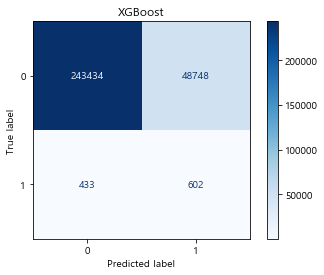

In [84]:
plot_confusion_matrix(xgb_over_model#######
                      ,X_test,y_test,cmap='Blues')

plt.title('XGBoost') ##############
plt.savefig('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/시나리오1/png/XGBoost.png') ##############
plt.show()

In [87]:
#모델저장
import pickle as pkl
with open("xgb_model.pkl",'wb') as outfile:
    pkl.dump(xgb_over_model,outfile)

In [88]:
#모델저장
import pickle as pkl
with open("xgb_pred.pkl",'wb') as outfile:
    pkl.dump(xgb_over_pred,outfile)

In [257]:
xgb_over_model.feature_importances_

array([4.2751371e-03, 3.8005528e-03, 7.1354387e-03, 0.0000000e+00,
       1.2235556e-04, 1.0285889e-02, 8.3443873e-02, 3.3407782e-03,
       1.3066170e-02, 8.2471911e-03, 4.1291751e-02, 7.2349707e-04,
       4.2543192e-03, 2.4597144e-03, 4.2940988e-03, 0.0000000e+00,
       4.2475727e-01, 3.2855291e-02, 4.0648477e-03, 7.8935531e-04,
       1.5363278e-03, 0.0000000e+00, 1.6743250e-02, 4.4766904e-04,
       2.1936342e-03, 7.7150986e-03, 0.0000000e+00, 3.0995684e-03,
       0.0000000e+00, 7.4479645e-03, 1.1942039e-02, 5.3886008e-03,
       1.1555291e-03, 0.0000000e+00, 0.0000000e+00, 1.3883708e-01,
       1.3186245e-02, 3.1372264e-04, 0.0000000e+00, 3.9815367e-03,
       0.0000000e+00, 2.1182508e-03, 2.4731213e-03, 3.1486352e-03,
       0.0000000e+00, 0.0000000e+00, 3.2928856e-03, 9.8350144e-04,
       1.8469762e-03, 9.5055103e-03, 1.5740907e-03, 4.4102934e-03,
       0.0000000e+00, 0.0000000e+00, 1.8814707e-02, 7.0213065e-03,
       3.9489740e-03, 0.0000000e+00, 1.5478710e-02, 6.2187236e

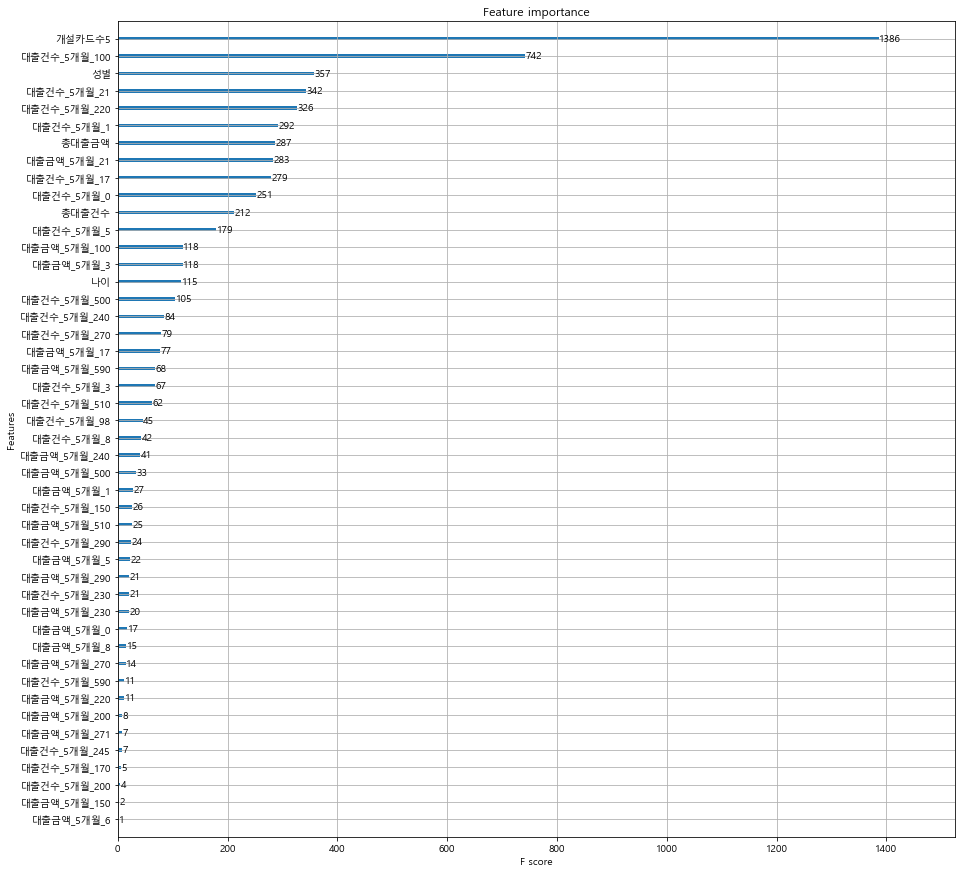

In [258]:
from xgboost import plot_importance

fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_over_model.get_booster(), ax=ax)

## 2) LightGBM

In [64]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=100)

In [65]:
lgbm.fit(X_train_over, y_train_over, early_stopping_rounds=10, eval_set = [(X_train_over, y_train_over), (X_test, y_test)], eval_metric='logloss')

[1]	training's binary_logloss: 0.641031	valid_1's binary_logloss: 0.641305
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.597606	valid_1's binary_logloss: 0.598427
[3]	training's binary_logloss: 0.560484	valid_1's binary_logloss: 0.562162
[4]	training's binary_logloss: 0.52876	valid_1's binary_logloss: 0.531353
[5]	training's binary_logloss: 0.501849	valid_1's binary_logloss: 0.504923
[6]	training's binary_logloss: 0.478843	valid_1's binary_logloss: 0.482385
[7]	training's binary_logloss: 0.458842	valid_1's binary_logloss: 0.462691
[8]	training's binary_logloss: 0.441647	valid_1's binary_logloss: 0.446481
[9]	training's binary_logloss: 0.425649	valid_1's binary_logloss: 0.431191
[10]	training's binary_logloss: 0.412314	valid_1's binary_logloss: 0.41875
[11]	training's binary_logloss: 0.399307	valid_1's binary_logloss: 0.406185
[12]	training's binary_logloss: 0.384468	valid_1's binary_logloss: 0.391341
[13]	training's binary_logloss: 0.3717

LGBMClassifier()

In [68]:
lgbm_pred = lgbm.predict(X_test)

In [67]:
print('<OverSampling 후 LightGBM 기본 모델 성능>')
model_assessment(y_test, lgbm_pred)

<OverSampling 후 LightGBM 기본 모델 성능>
accuracy 0.9881214254289485 

confusion_matrix [[289650   2532]
 [   951     84]] 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    292182
           1       0.03      0.08      0.05      1035

    accuracy                           0.99    293217
   macro avg       0.51      0.54      0.52    293217
weighted avg       0.99      0.99      0.99    293217



In [69]:
auc = auc_return(y_test,lgbm_pred) # 변경
print(auc)

0.5362467943595609


## 3) RandomForest

In [70]:
rfc = RandomForestClassifier(n_estimators=100, random_state=146)
rfc.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=146)

In [71]:
rfc_prd = rfc.predict(X_test)

In [72]:
print('<OverSampling 후 RandomForest 기본 모델 성능>')

model_assessment(y_test,rfc_prd)

<OverSampling 후 RandomForest 기본 모델 성능>
accuracy 0.9925618228138204 

confusion_matrix [[291005   1177]
 [  1004     31]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292182
           1       0.03      0.03      0.03      1035

    accuracy                           0.99    293217
   macro avg       0.51      0.51      0.51    293217
weighted avg       0.99      0.99      0.99    293217



In [78]:
auc = auc_return(y_test,rfc_prd) # 변경
print(auc)

0.5129616898500527


## 4) Decision Tree

In [74]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train_over, y_train_over)

In [75]:
dt_pred = dt.predict(X_test)

In [76]:
print('<OverSampling 후 Decision Tree 기본 모델 성능>')

model_assessment(y_test,dt_pred)

<OverSampling 후 Decision Tree 기본 모델 성능>
accuracy 0.9834866327668587 

confusion_matrix [[288301   3881]
 [   961     74]] 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    292182
           1       0.02      0.07      0.03      1035

    accuracy                           0.98    293217
   macro avg       0.51      0.53      0.51    293217
weighted avg       0.99      0.98      0.99    293217



In [77]:
auc = auc_return(y_test,dt_pred) # 변경
print(auc)

0.5291073838333245


## 5) Gradient Boosting

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=21,max_depth = 5)
gbc.fit(X_train_over, y_train_over)

GradientBoostingClassifier(max_depth=5, random_state=21)

In [80]:
gbc_pred = gbc.predict(X_test)

In [81]:
print('Gradient Boosting 기본 모델 성능')

model_assessment(y_test,gbc_pred)

Gradient Boosting 기본 모델 성능
accuracy 0.9499278691208218 

confusion_matrix [[278259  13923]
 [   759    276]] 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    292182
           1       0.02      0.27      0.04      1035

    accuracy                           0.95    293217
   macro avg       0.51      0.61      0.51    293217
weighted avg       0.99      0.95      0.97    293217



In [82]:
auc = auc_return(y_test,rfc_prd) # 변경
print(auc)

0.5129616898500527


In [92]:
#모델저장
import pickle as pkl
with open("gbc_model.pkl",'wb') as outfile:
    pkl.dump(gbc,outfile)

In [93]:
#모델저장
import pickle as pkl
with open("gbc_predict.pkl",'wb') as outfile:
    pkl.dump(gbc_pred,outfile)

## 5) CatBoost